# Task Given

### Example Coding Project 

We would like for you to submit a coding project that you have completed that you feel best showcases your abilities. 
Examples include, but are not at all limited to: <br><br>
• Machine learning problems <br>
• Libraries <br>
• Applications <br>

This is purposefully open-ended to allow you the opportunity to show off your skills and demonstrate the  type of work product you can produce. <br><br>
Typically, candidates submit a repository link (github, gitlab, etc), an archive (zip, gzip, etc), jupyter notebook, Kaggle Code notebook, etc. <br><br>
Please do not submit a project that is confidential or would generally not be acceptable for public  distribution. At the conclusion of your interview process, all information pertaining to your project (links,  files, etc) will be deleted.<br> <br>
Please submit your name and project to alex.houston@crowe.com.


# Task chosen

**Aim**: To identify weather a given News Headline is sarcastic or not. Also, to make a flask API off the chosen trained model.<br>

**Scenario**: Our model is being used by an online News-firm to detect if a given headline is Sarcastic or not. The numbers of articles the firms deals with is in thousands. If our model classifies a given headline as sarcastic, then only it is manually reviewd, otherwise the article is published along with the same headline. If an article with sarcastic headline is published then the news firm can face serious repercussions.

**Problem Domain**: NLP <br>

**Data**: Publicaly available News Headline data <br>

**Approach**: <br>
It is clear that the chosen problem is a classification problem over text data. On a broader sense, there are two choices to be made. One is which classification algorithm to use, second one being which text representation to use. <br><br>

Since, there are multiple algorithms and representations available for solve the text classification problem, we need to try them out to find which best fits our data before deploying anything for the customer.<br><br>

In the cells below, following text-representations and classification algorithms have been tried to fit on the data: <br>
Classification algorithms: Naive Bayes, Logistic regression, SVM, LSTM <br>
Representations: Bag of words, Tf-IDF, word2vec <br>

**About the given solution**: <br>

**GIT branchs** <br>
- develop: contains jupyter notebook and associated python files
- deployment: contains a flask API for the selected model from the develop branch

**About Python files**: <br>
- models.py: contains code for classification algorithms used
- representations.py: contains code for different text-representations used
- util.py: contains helper methods used

**About google sheet**:
- linked google sheet contains results of experimentation done on the dataset with various algorithms

<br><br><br>
<b>Further explanation for path chosen and decisions taken during the assignment can be found along with the code and in markdown cells</b>

# Sarcasm Detection

In [1]:
## Loading required libraries

## data manipulation libraries
import pandas as pd
import numpy as np

## import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_auc_score

## loading modeling related libraires and methods
from sklearn.model_selection import train_test_split
from models import naive_bayes, logistic_regression, svm

## loading text-representations related libraries and methods

from representations import embedding_feats ## returns vector representation of all the documents
from representations import make_embedding_dict
from representations import BoW_representation, tf_idf_representation, word2Vec

from utils import clean, plot_confusion_matrix, get_confusion_matrix, print_metrics, get_class, take

## to save artifacts to use during inference time
import pickle

In [2]:
## reading data
data_s = pd.read_json('data/Sarcasm_Headlines_Dataset.json', lines= True)
data_s.shape

(26709, 3)

In [3]:
data_s.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## Some basic EDA and data cleaning

- Since publicaly provided data is being used, expecting it to be quite clean 

In [4]:
## checking duplicate rows existence 
data_s.duplicated().sum()

## there's one duplicate row

1

In [5]:
## Dropping duplicates rows
data_s.drop_duplicates(inplace=True)
print('dataframe shape: ', data_s.shape)

dataframe shape:  (26708, 3)


In [6]:
## checking duplicates in the headline column 
data_s[['headline']].duplicated().sum()

106

In [7]:
## Removing rows with duplicates headlines since keeping duplicates in headline gives model no useful infoemation
data_s.drop_duplicates(subset='headline', keep='last', inplace=True)
print('dataframe shape: ', data_s.shape)

dataframe shape:  (26602, 3)


In [8]:
print('Dataset size after cleaning: ',data_s.shape)
print('Number of unique articles link: '+str(data_s['article_link'].unique().shape[0]))
print('Number of unique headline: '+ str(data_s['headline'].unique().shape[0]))

Dataset size after cleaning:  (26602, 3)
Number of unique articles link: 26602
Number of unique headline: 26602


In [9]:
print('Sarcastic Comments: ', data_s['is_sarcastic'].value_counts()[1])
print('Non-Sarcastic Comments: ', data_s['is_sarcastic'].value_counts()[0])
print()
print('Sarcastic Comments percentage: ', data_s['is_sarcastic'].value_counts()[1]/data_s.shape[0]*100)
print('Non-Sarcastic Comments percentage: ', data_s['is_sarcastic'].value_counts()[0]/data_s.shape[0]*100)

Sarcastic Comments:  11651
Non-Sarcastic Comments:  14951

Sarcastic Comments percentage:  43.79745883768138
Non-Sarcastic Comments percentage:  56.20254116231862


**From the percentage in both categories, it can be seen that the given data is not imbalanced, and our model will therefore might not suffer from class imbalanced problem** <br><br><br>

**More EDA is done as needed per the situtaion in cells below in the notebook** <br><br><br>

**To identify wheather a News headline is sarcastic or not, the article link won't prove to be of much help. Therefore, we will drop the column**

In [10]:
data_s.drop(['article_link'], axis= 1, inplace=True)
data_s.head(2)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0


# Choice of metric

- In any ML/DL project, choice of metric is very important to get started with the problem. This helps in comparing the results of different trained model and also to ascertain if we are meeting the business requirement.
- We will take **F1-score** as deciding metric between models. Also, **to meet the Scenario requirement** given above, we will try to increase recall as much as possible. While focusing less on the precision. I.e. Given same f1-score between two models, we will choose the one which have better **Recall**
<br><br><br><br><br>

# General approach to tackle the problem at hand

- It is advisable to quickly make baseline model up and running with proper metric.
- I will be using NB with BoW representation as the baseline. The perfomance of the model can be easily found in the google sheet.
- After the baseline, other algorithms will be tried with default settings to see which one best fits the data. 
- Naive Bayes, Logictic Regression, and SVM will be tried upon with BoW, Tf-TDF, and word2vec. LSTM and BI-LSTM will be applied on word2vec.
- The performance of these approaches is compared as per chosen metric.
- The algorithm which fits the data best and give best result on testing set will be chosen to do deeper error-analysis in an effort to further enhance this selected model.
- the selected model will be deployed using flask in the deployment branch.

In [11]:
## train-test split 
## same-split to be used across all algorithms since we want comparative study 

X = data_s.headline 
y = data_s.is_sarcastic  
print('Total data shape, X and Y')
print(X.shape, y.shape)

## random_state=1 for reproducibility #75%-25% default train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1) 
print()
print('Train data shape, X and Y')
print(X_train.shape, y_train.shape)
print('Test data shape, X and Y')
print(X_test.shape, y_test.shape)

Total data shape, X and Y
(26602,) (26602,)

Train data shape, X and Y
(19951,) (19951,)
Test data shape, X and Y
(6651,) (6651,)


In [12]:
## A look at the train data

In [13]:
X_train

12897    victoria's secret introduces 3-inch patch of s...
23365                             the power of perspective
17425    democrats fear that expectations for donald tr...
15768     how we became the heaviest drinkers in a century
7287     what the trump team should consider before axi...
                               ...                        
11018                 rain told to go away in 1986 returns
17384    woman already off to bad start as mother after...
5225     anne hathaway, james franco spend every moment...
12245    area woman insists on helping coworker through...
236      discover how climate change is rapidly transfo...
Name: headline, Length: 19951, dtype: object

In [15]:
print(X_train[17425])
print(clean(X_train[17425]))

democrats fear that expectations for donald trump are a wee bit too low
democrats fear expectations donald trump wee bit low


## Trying BoW representation

### NB on BoW

In [16]:
## Preprocess and Vectorize train and test data

## getting BoW representaiton for our data
X_train_dtm, X_test_dtm = BoW_representation(X_train, X_test)

train data: (19951, 23705) test data: (6651, 23705)


Prediction at training data
F1 Score:  0.9094272007398416
Recall:  0.8994969128744569
Precision:  0.9195791934541204

Prediction at testing data
F1 Score:  0.7698300283286119
Recall:  0.7483648881239243
Precision:  0.7925628873496172


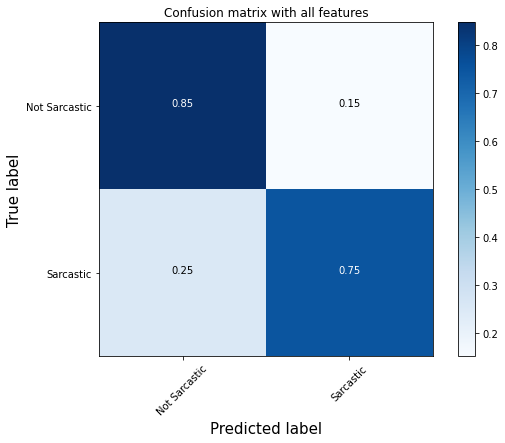

In [17]:
y_pred_class_train, y_pred_class = naive_bayes(X_train_dtm, y_train, X_test_dtm)

# Print accuracy:
print("Prediction at training data")
print_metrics(y_train, y_pred_class_train)
print()
print("Prediction at testing data")
print_metrics(y_test, y_pred_class)
# print the confusion matrix
get_confusion_matrix(y_test, y_pred_class)

### Observation

- Model has train and test f1-score of 0.91 and 0.77 for full vocab. Good enough for a baseline.
- NB with 10000 vocab gives about the same performance at test set, and we see less overfitting.
- Using all 23705 features is causing overfitting in the model. In conclusion, using all 23705 isn't adding much value to the model.
- Reason for MultinomialNB version Naive Bayes: In the sklearn website, it is mentioned that this version of the naive bayes is typically used/empirically better for text classification

### Logictic regression on BoW

Prediction at training data
F1 Score:  0.9492889115530625
Recall:  0.957809284244226
Precision:  0.9409187914186229

Prediction at testing data
F1 Score:  0.7615033368458025
Recall:  0.7462994836488812
Precision:  0.7773395482251703


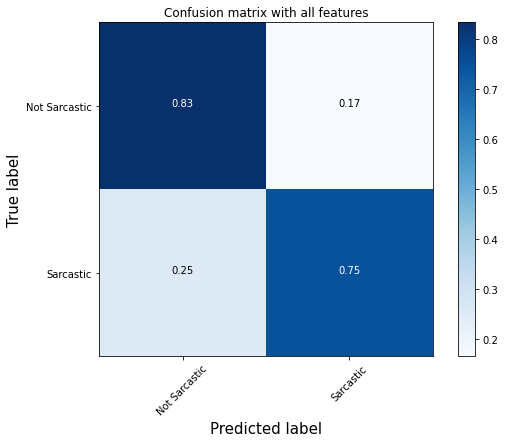

In [18]:
y_pred_class_train, y_pred_class = logistic_regression(X_train_dtm, y_train, X_test_dtm)

# calculate evaluation measures:
print("Prediction at training data")
print_metrics(y_train, y_pred_class_train)
print()
print("Prediction at testing data")
print_metrics(y_test, y_pred_class)

get_confusion_matrix(y_test, y_pred_class)

### Observation

- More overfitted then NB
- About same performance at test set

### SVM on BoW

train data: (19951, 10000) test data: (6651, 10000)
Prediction at training data
F1 Score:  0.9632620564149227
Recall:  0.9683283786874
Precision:  0.9582484725050916

Prediction at testing data
F1 Score:  0.7330427201394943
Recall:  0.7235800344234079
Precision:  0.742756183745583


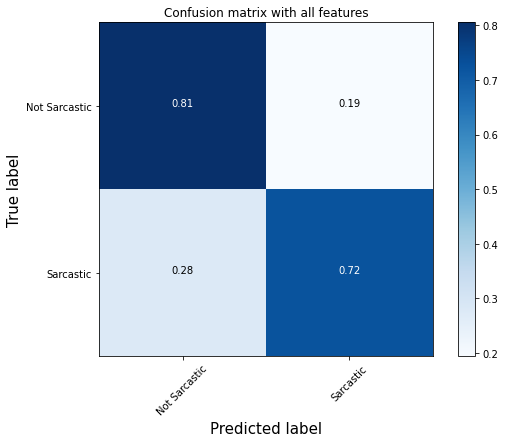

In [19]:
X_train_dtm, X_test_dtm = BoW_representation(X_train, X_test, max_features = 10000)
y_pred_class_train, y_pred_class = svm(X_train_dtm, y_train, X_test_dtm)

# calculate evaluation measures:
print("Prediction at training data")
print_metrics(y_train, y_pred_class_train)
print()
print("Prediction at testing data")
print_metrics(y_test, y_pred_class)

get_confusion_matrix(y_test, y_pred_class)

### Observation

- More overfitted then NB and logistic regression
- Lower performance on test set
- trying with 5000 features shows improvment in overfitting with no degredation in test set performance

## Trying TF-IDF representation of text with the same settings

### NB on TF-IDF

In [20]:
## TF-IDF text representation for train_X and test_X
X_train_tfidf, X_test_tfidf = tf_idf_representation(X_train, X_test)

train data: (19951, 23705) test data: (6651, 23705)


In [21]:
type(X_train_tfidf)

scipy.sparse.csr.csr_matrix

Prediction at training data
F1 Score:  0.8880574127461204
Recall:  0.8276926595014864
Precision:  0.9579198094481938

Prediction at testing data
F1 Score:  0.7311449785072294
Recall:  0.6440619621342513
Precision:  0.8454586534116584


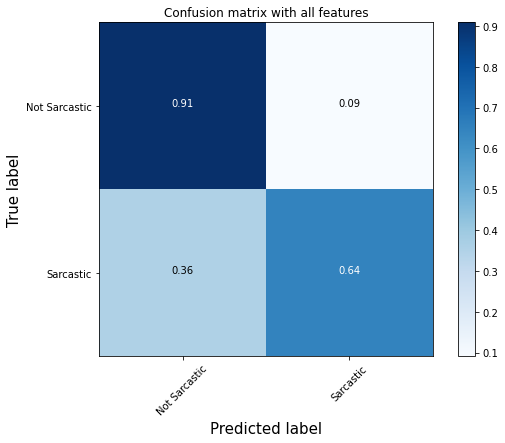

In [22]:
y_pred_class_train, y_pred_class = naive_bayes(X_train_tfidf, y_train, X_test_tfidf)

# Print accuracy:
print("Prediction at training data")
print_metrics(y_train, y_pred_class_train)
print()
print("Prediction at testing data")
print_metrics(y_test, y_pred_class)
# print the confusion matrix
get_confusion_matrix(y_test, y_pred_class)

### Observation

- Tf-IDF on NB is performing poor in compariso to the BoW representation.
- High ovrefitting still observed.
- Tf-IDf is performing good interms of accuracy as compared to Recall.

### Logictic regression on TF-IDF

Prediction at training data
F1 Score:  0.8963180483397335
Recall:  0.9073862337068375
Precision:  0.8855166257531801

Prediction at testing data
F1 Score:  0.7670053383847081
Recall:  0.7666092943201377
Precision:  0.7674017918676774


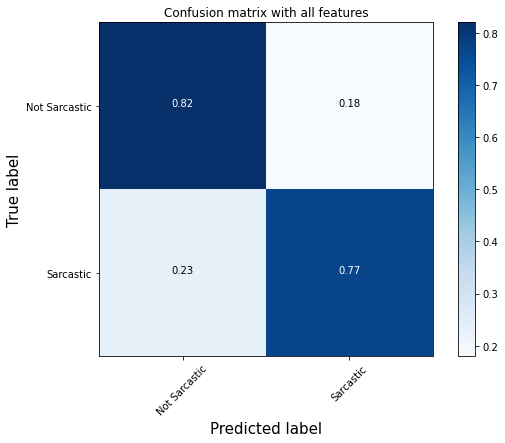

In [23]:
y_pred_class_train, y_pred_class = logistic_regression(X_train_tfidf, y_train,  X_test_tfidf)

# calculate evaluation measures:
print("Prediction at training data")
print_metrics(y_train, y_pred_class_train)
print()
print("Prediction at testing data")
print_metrics(y_test, y_pred_class)

get_confusion_matrix(y_test, y_pred_class)

### Observation

- Tf-IDF on LR is performing better in compariso to the BoW representation with LR.
- High ovrefitting still observed,but less than BoW.

### SVM on TF-IDF

train data: (19951, 5000) test data: (6651, 5000)
Prediction at training data
F1 Score:  0.875339366515837
Recall:  0.8847473130573976
Precision:  0.8661293933288561

Prediction at testing data
F1 Score:  0.742086144265698
Recall:  0.7383820998278829
Precision:  0.7458275382475661


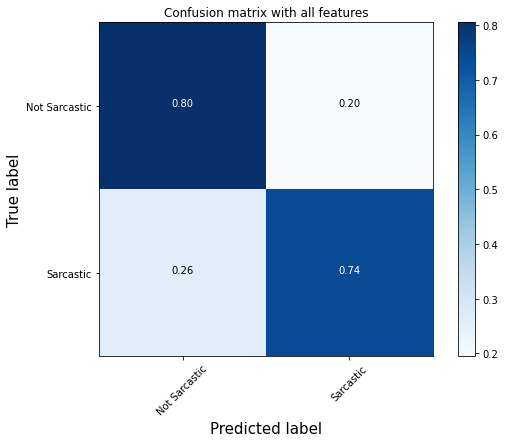

In [24]:
X_train_tfidf, X_test_tfidf = tf_idf_representation(X_train, X_test, max_features=5000)
y_pred_class_train, y_pred_class = svm(X_train_tfidf, y_train, X_test_tfidf)

# calculate evaluation measures:
print("Prediction at training data")
print_metrics(y_train, y_pred_class_train)
print()
print("Prediction at testing data")
print_metrics(y_test, y_pred_class)

get_confusion_matrix(y_test, y_pred_class)

### Observation

- Tf-IDF on SVM is performing about same as BoW representation with SVM.
- High ovrefitting still observed,but less than BoW.
<br><br><br>

## In conclusion

- With BoW and Tf-IDF represenations, we have to deal large feature space. This is casusing the models to overfit. 
- To work with these represenations only as working solution, we can try reducing the feature space more, and using hand made feature and doing error analysis to improve performance.
- But before doing point 2, it will be better to try out word2Vec with these algorithms which deals in less feature space. And also, each word vector has meaning associated with it. Which is not the case with either BoW or Tf-Idf.

### word2vec

In [25]:
X_train

12897    victoria's secret introduces 3-inch patch of s...
23365                             the power of perspective
17425    democrats fear that expectations for donald tr...
15768     how we became the heaviest drinkers in a century
7287     what the trump team should consider before axi...
                               ...                        
11018                 rain told to go away in 1986 returns
17384    woman already off to bad start as mother after...
5225     anne hathaway, james franco spend every moment...
12245    area woman insists on helping coworker through...
236      discover how climate change is rapidly transfo...
Name: headline, Length: 19951, dtype: object

In [26]:
## Get word2vec representation for training and testing data
X_train_we, X_test_we = word2Vec(X_train, X_test)

In [27]:
X_train_we[0]

array([-0.23838546,  0.10318487,  0.13363733, -0.04988057,  0.07965822,
        0.10855173,  0.10495087,  0.3963785 , -0.05049869,  0.07243779,
        0.10436315,  0.09710588,  0.14620144,  0.21194598,  0.07483703,
        0.2417487 ,  0.33634232, -0.0363492 ,  0.20186313, -0.36218156,
       -0.11339798, -0.17872353, -0.08941489,  0.03141593,  0.40075113,
        0.09936775, -0.01035727, -0.40433025, -0.05889492, -0.0409207 ,
        0.15511656,  0.01877549, -0.0046575 , -0.18079315,  0.11046099,
        0.22132397,  0.04336732,  0.26583716,  0.27680841,  0.06745079,
        0.05373669, -0.38156036,  0.09302114, -0.23275759, -0.49860513,
       -0.02463122, -0.20589512,  0.19480963,  0.05016181, -0.06960116,
       -0.14915806,  0.07111554,  0.09218301,  0.92622259, -0.22857221,
       -1.35715831, -0.14865681,  0.06287892,  0.74622282,  0.12930096,
       -0.04630744,  0.54277058, -0.27054553,  0.32035827,  0.45623192,
       -0.23982608,  0.20899709,  0.07825565, -0.06272355, -0.17

In [28]:
X_train_we[0].shape

(100,)

### cannot try NB with word2vec, NB doesn't work with negative values in feature space.

Prediction at training data
F1 Score:  0.6794069192751235
Recall:  0.707294763320375
Precision:  0.6536348267117498

Prediction at testing data
F1 Score:  0.667888074616922
Recall:  0.6901893287435457
Precision:  0.6469828977089384


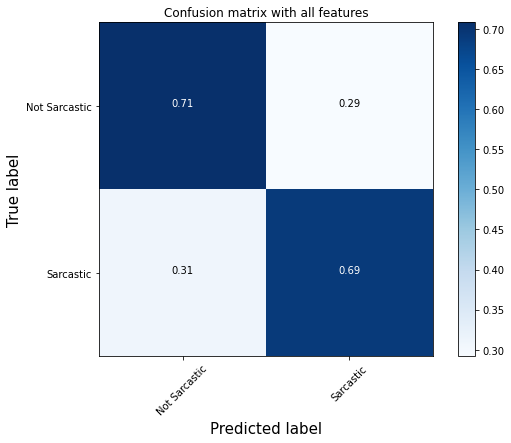

In [29]:
# Preprocess and Vectorize train and test data
y_pred_class_train, y_pred_class = logistic_regression(X_train_we, y_train, X_test_we)

# Print accuracy:
print("Prediction at training data")
print_metrics(y_train, y_pred_class_train)
print()
print("Prediction at testing data")
print_metrics(y_test, y_pred_class)
# print the confusion matrix
get_confusion_matrix(y_test, y_pred_class)

C:\Users\Daas\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Prediction at training data
F1 Score:  0.6797780585617756
Recall:  0.707409101303453
Precision:  0.6542243840541397

Prediction at testing data
F1 Score:  0.6683333333333333
Recall:  0.6901893287435457
Precision:  0.6478190630048465


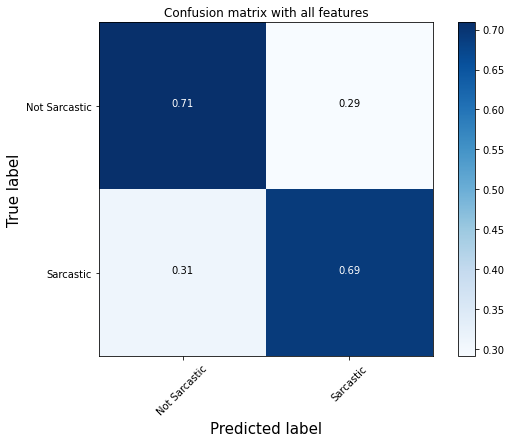

In [30]:
y_pred_class_train, y_pred_class = svm(X_train_we, y_train, X_test_we)

# Print accuracy:
print("Prediction at training data")
print_metrics(y_train, y_pred_class_train)
print()
print("Prediction at testing data")
print_metrics(y_test, y_pred_class)
# print the confusion matrix
get_confusion_matrix(y_test, y_pred_class)

### Observations

- word2vec is not able to fit the data properly. this can be seen as low F1-score as compared to Bow and Tf-Idf.
- There little to no overfitting. This can be attributed to low feature space.
- If choice to be made between BoW/Tf-IDF and word2vec, word2vec will be choice here, since:
    - the f1-score is less only by a small margin.
    - preformance should increase easily if we use a higher dimensional WE.
    - using higher dimensional WE is easier than making hand features to improve performance in BoW/Tf-IDF.

## Trying LSTM with word2vec

In [31]:
## to get reproducible results

from tensorflow import random
from numpy.random import seed
seed(1)
random.set_seed(1)

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Flatten, Bidirectional
from tensorflow.keras.models import Model, Sequential

In [33]:
data_s.head(2)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0


### Deciding on model parameters:

- LSTM architecture expects the input to be of same length - Analysis done below
- we will be using Adam optimizer with dafault learning rate of 0.001 for now. Other parameters of Adam optimizer also used on default setting.
- Number of words to be used from the total vocabulary - ML models above performed well 10000 and 5000 as well. So, we will be using 10000 most frequent words for now with LSTM.
- uisng glove 100d embedding: word2vec with LSTM has shown to give good performance.
<br><br><br><br>
- Model architecture is selected as Uni-directional LSTM for now. Reason being:
    - We are choosing the sentence length as 15. So using memory cells feature of LSTM will definitely be helpful here to classify.
    - Upon choosing LSTM, we need to choose wheather to use BI-LSTM or Uni-directional LSTM. For our usecase, we just need the model predict one outcome after going through each document, and not after each time-step. Uni-directional LSTM seems to be enough for this usecase. We will experiment with both LSTM and BI-LSTM.


In [34]:
## setting features
max_features = 10000  ## no of unique words in the vocabulary
embedding_size = 100 ## length of word embedding

num_words =  max_features+1
## initializing tokenizer object, this pre-process the text documents as well
tokenizer = Tokenizer(
    num_words=num_words,
     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
     lower=True,
     split=" ",
     oov_token = True)

tokenizer.fit_on_texts(data_s['headline'])

In [35]:
data_s.head(2)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0


In [36]:
data_s['tokenized_headline'] = tokenizer.texts_to_sequences(data_s['headline'])

In [37]:
data_s.head(2)

,headline,is_sarcastic,tokenized_headline
0,former versace store clerk sues over secret 'b...,0,"[308, 1, 677, 3611, 2293, 48, 382, 2566, 1, 6,..."
1,the 'roseanne' revival catches up to our thorn...,0,"[4, 8414, 3332, 2741, 22, 2, 165, 8415, 414, 3..."


In [38]:
data_s['len']  = data_s.apply(lambda x : len(x['tokenized_headline']), axis = 1)
data_s['len'].describe()

count    26602.000000
mean        10.063867
std          3.206280
min          2.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         40.000000
Name: len, dtype: float64

<b>75% value comes at length 12, so chossing 15 as document the length. This will make sure that for about 80% of documents, we are not trimming anything.</b>

In [39]:
maxlen = 15 ## no of words to use from each headline

X = data_s['tokenized_headline']
X = pad_sequences(X, maxlen = maxlen, value=0.0)
y = np.asarray(data_s['is_sarcastic'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 26602
[   0    0    0  308    1  677 3611 2293   48  382 2566    1    6 2567
 8413]
Number of Labels:  26602
0


In [40]:
print('Number of words originally present:', len(tokenizer.word_index) + 1)

print('Numer of words in our vocabulary: ', max_features, '.Since, we had set num_words argumnet while defining tokenizer object')

Number of words originally present: 29658
Numer of words in our vocabulary:  10000 .Since, we had set num_words argumnet while defining tokenizer object


In [41]:
vocab = take(num_words, tokenizer.word_index.items())

## Sanity check for word embeddings(WE)

- When using WE, We should check the overlap between our dictionary with WE that we are using. An 80% or above overlap in known to give good results

In [42]:
## making embedding dictionary
embeddings = make_embedding_dict()

## checking for vocab intersection
words=set(vocab.keys())
embeddings_words = set(embeddings.keys())
intersect_word = words.intersection(embeddings_words)

print("vocab intersection:", len(intersect_word)/ len(vocab))

vocab intersection: 0.9315068493150684


<b>We have an vocab intersection of 93%. We are in the green zone.</b>

In [43]:
## making embedding_matrix to give as input to the model
embedding_matrix = np.zeros((num_words+1, 100))

for word, i in vocab.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

In [44]:
# Defining the Keras model
model = Sequential()
model.add(Embedding(num_words + 1, embedding_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Dropout(0.50))

# model.add(Bidirectional(LSTM(128, return_sequences=True)))  ## un-comment for experimenting with BI-LSTM
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dropout(0.50))

model.add(Dense(1, activation='sigmoid'))

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           1000200   
_________________________________________________________________
dropout (Dropout)            (None, 15, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 15, 128)           117248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [46]:
## Model Configuration
batch_size = 100
number_of_epochs = 10

loss_function = 'binary_crossentropy'
optimizer = 'adam'
additional_metrics = ['accuracy']
verbosity_mode = True

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19951, 15), (6651, 15), (19951,), (6651,))

In [48]:
X_train

array([[   0,    0, 6831, ..., 4579,    8,  299],
       [   0,    0,    0, ...,  355,    3, 2359],
       [   0,    0,  376, ..., 2418,  151,  768],
       ...,
       [   0,    0, 2812, ...,   43, 6602,    1],
       [   0,    0,    0, ...,  174,  607,  503],
       [   0,    0,    0, ...,   10,  909,    1]])

In [49]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)

# Train the model
history = model.fit(X_train, y_train, epochs=number_of_epochs,
                    batch_size=batch_size, 
                    verbose=verbosity_mode, 
                    validation_data=(X_test,y_test))

Epoch 1/10
200/200 [==============================] - 18s 54ms/step - loss: 0.6211 - accuracy: 0.6501 - val_loss: 0.5130 - val_accuracy: 0.7510
Epoch 2/10
200/200 [==============================] - 10s 49ms/step - loss: 0.5464 - accuracy: 0.7225 - val_loss: 0.4469 - val_accuracy: 0.7964
Epoch 3/10
200/200 [==============================] - 11s 55ms/step - loss: 0.4885 - accuracy: 0.7623 - val_loss: 0.4145 - val_accuracy: 0.8056
Epoch 4/10
200/200 [==============================] - 10s 50ms/step - loss: 0.4510 - accuracy: 0.7853 - val_loss: 0.3897 - val_accuracy: 0.8245
Epoch 5/10
200/200 [==============================] - 10s 50ms/step - loss: 0.4329 - accuracy: 0.7960 - val_loss: 0.3872 - val_accuracy: 0.8218
Epoch 6/10
200/200 [==============================] - 10s 50ms/step - loss: 0.4229 - accuracy: 0.8020 - val_loss: 0.3577 - val_accuracy: 0.8430
Epoch 7/10
200/200 [==============================] - 10s 50ms/step - loss: 0.4056 - accuracy: 0.8138 - val_loss: 0.3602 - val_accuracy:

#### Epoch count
- At 5 epochs, we see that val error is still incresing well. Higher epoch count should be tried
- At 10 epochs, about same f1-score, but recall is higher, which is better suited for us. Selecting epoch count as 10 for further experimentation. 

In [50]:
X_test

array([[   0,    0,    0, ...,  554,   29, 2122],
       [   0,    0,    0, ...,  268,  130,  104],
       [   0,    0,    0, ..., 8068,   64, 1171],
       ...,
       [   0,    0,    0, ..., 5336,  250, 1768],
       [ 731,   93, 1959, ...,    4,  330, 3057],
       [   0,    0,    0, ...,  470,    8, 5283]])

In [51]:
## getting prediction from the trained model
y_pred_prob = model.predict(X_test).flatten()
y_pred_prob_train = model.predict(X_train).flatten()

In [52]:
threshold = 0.35
y_pred_class = get_class(y_pred_prob, threshold)
y_pred_class_train = get_class(y_pred_prob_train, threshold)

Prediciton on training data
F1 Score:  0.8588754720995798
Recall:  0.9230505373885205
Precision:  0.8030438675022381

Prediction at testing data
F1 Score:  0.8348049446139028
Recall:  0.8950086058519794
Precision:  0.7821901323706378


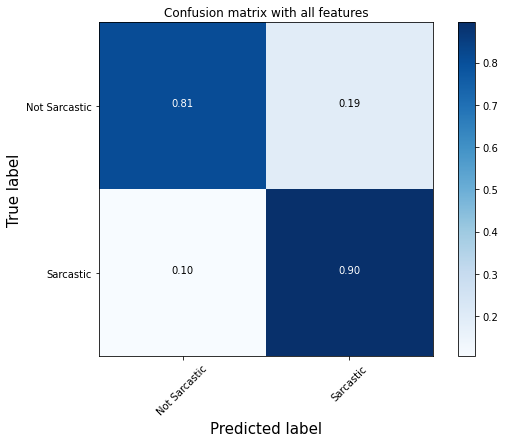

In [53]:
# calculate evaluation measures:
# print("Prediction at training data")
print("Prediciton on training data")
print_metrics(y_train, y_pred_class_train)
print()
print("Prediction at testing data")
print_metrics(y_test, y_pred_class)

get_confusion_matrix(y_test, y_pred_class)

## Oberservations

- This is by far the best result obatined.
- Overfitting is very less compared to above scenarios.
- f1-score is better compared to above scenarios.
- **Selcting this model as the one to be deployed for now**. Therefore, going a bit deeper into the predicitons for this one, and see if we can increase the performance.
- Also, no performance jump is observed by using BI-LSTM. Choosing LSTM as our choice of model.

# Error analysis

- Important part to improve model performance

### Generating text back from the tokenized text. Useful, in-case we want to read the original text while doing error analysis

In [54]:
X_test_padding_removed = []
for seq in X_test:
    X_test_padding_removed.append([item for item in seq if item not in  [0,1]]) ## removing 0 - OOV and 1 - True
    
seq_to_text =  tokenizer.sequences_to_texts(X_test_padding_removed)

In [55]:
X_test_df = pd.DataFrame({'News_Headline': seq_to_text, 
                          'True_label': y_test, 
                          'Predicted_label': y_pred_class, 
                         'Predicted_Prob': y_pred_prob.flatten()})

In [56]:
X_test_df.shape

(6651, 4)

In [57]:
X_test_df.head()

,News_Headline,True_label,Predicted_label,Predicted_Prob
0,woman assures you she's not mad,1,1,0.956683
1,insurers blast new in senate health bill,0,0,0.182534
2,stock car booed off track,1,1,0.876972
3,jones tells jimmy fallon he doesn't want to pl...,1,1,0.628009
4,holy crap british artist will cast your in bro...,0,0,0.311876


In [58]:
X_test_df['True_label'].value_counts()

0    3746
1    2905
Name: True_label, dtype: int64

In [59]:
## probablity stats for True_label=1 
X_test_df.loc[(X_test_df.True_label) == 1, 'Predicted_Prob'].describe()

count    2905.000000
mean        0.746628
std         0.251980
min         0.009192
25%         0.602407
50%         0.836891
75%         0.953295
max         0.999736
Name: Predicted_Prob, dtype: float64

In [60]:
## probablity stats for True_label=1 
X_test_df.loc[(X_test_df.True_label) == 0, 'Predicted_Prob'].describe()

count    3746.000000
mean        0.190236
std         0.224531
min         0.000942
25%         0.029225
50%         0.089718
75%         0.273564
max         0.990499
Name: Predicted_Prob, dtype: float64

#### Observation from probability distribution

Observing these probablity numbers at 75% in the above two cells tells us that the model is doing a pretty good job,
i.e. for most example,either positive or negative they seggregated quite well. <br> <br>

this also tells us that we can play around with the threshold of 0.50 to focus on either precision or recall with the
same model

### Intuition behind changing the threshold value

- As per our scenario, we want the Recall to be maximized. Therefore, by reducing the threshold from 0.5, if we can get jump the recall without hurting the f1-score too much, then it will be of value.
- Let's try 0.4 and 0.35 as threshold values. 
- Note: Threshold value should be obtained by AUC-ROC curve.

In [61]:
y_pred_class = get_class(y_pred_prob, 0.4)
y_pred_class_train = get_class(y_pred_prob_train, 0.4)

Prediciton on training data
F1 Score:  0.8623742894621775
Recall:  0.9020123485021724
Precision:  0.8260732984293194

Prediction at testing data
F1 Score:  0.8333333333333333
Recall:  0.8726333907056799
Precision:  0.7974205725070777


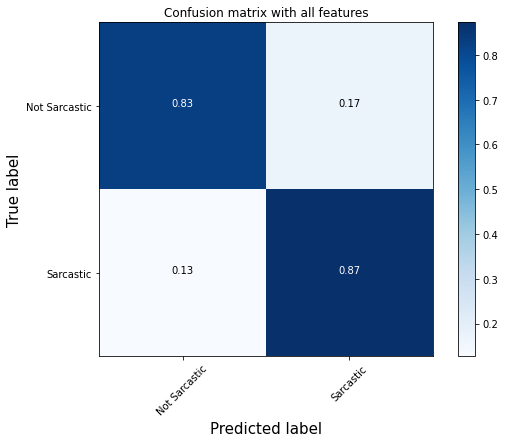

In [62]:
# calculate evaluation measures:
# print("Prediction at training data")
print("Prediciton on training data")
print_metrics(y_train, y_pred_class_train)
print()
print("Prediction at testing data")
print_metrics(y_test, y_pred_class)

get_confusion_matrix(y_test, y_pred_class)

### we can see a jump in both F1-score and Recall

In [63]:
## trying threshold = 0.35

y_pred_class = get_class(y_pred_prob, 0.35)
y_pred_class_train = get_class(y_pred_prob_train, 0.35)

Prediciton on training data
F1 Score:  0.8588754720995798
Recall:  0.9230505373885205
Precision:  0.8030438675022381

Prediction at testing data
F1 Score:  0.8348049446139028
Recall:  0.8950086058519794
Precision:  0.7821901323706378


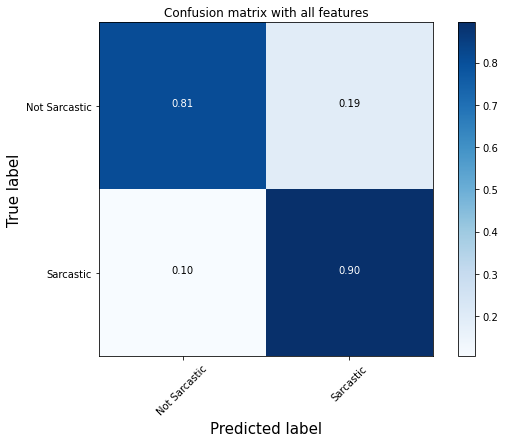

In [64]:
# calculate evaluation measures:
# print("Prediction at training data")
print("Prediciton on training data")
print_metrics(y_train, y_pred_class_train)
print()
print("Prediction at testing data")
print_metrics(y_test, y_pred_class)

get_confusion_matrix(y_test, y_pred_class)

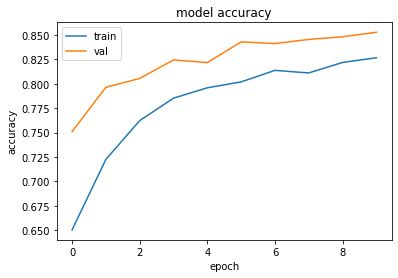

In [65]:
## Visualizing training process and overfitting

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### The Recall further increased to 89.5%, while f1-score hasn't decreased.

- With Recall at almost 90%, we can deploy this model for testing purpose on incoming headlines.
- This way we can collect more data, can also see the performance of our model on live data.
- In general, while this model is deployed, at the backend, we will continue to improve the model. 

### Further things that can be done on error-analysis

- look at samples examples of both correctly and incorrectly classified examples to get an idea of how our model is performing
- among the misclassified examples manully seen, seggregating them into different categories, i.e. examples getting misclassified from one reason should be in one category. Post this, based which type of error is more crucial and which is more percentage should be focused upon. This choice depends on business usecase. 

# Future Scope

- Do hypermeter tuning for LSTM model. As currently, mostly default parameters are used.
- Doing Manual error analysis to see if there is pattern in examples getting mis-classified.
- trying 300 dimensional word embeddings.
- Trying Transformers to get representation of the document. 

###  Saving the selected trained model for usage during deployment time

In [68]:
## saving both the model architectuire and weights

## model architecture
model_json = model.to_json()
with open("model_v1.json", "w") as json_file:
    json_file.write(model_json)

## model weights
model.save_weights("model_v1.h5")

In [66]:
# ## load model architecture

# from keras.models import model_from_json

# json_file = open('model_v1.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

# ## load model weights
# loaded_model.load_weights("model_v1.h5")

In [71]:
## saving the tokenizer to use at testing time

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Inference
### Deployment as a Flask API

- Code in deployment branch

**Sample JSON request**

{"review_text" : ["mom starting to fear sons web series closest", "democrats fear that expectations for donald trump are a wee bit too low"]}

<br><br>

**Sample output**

{
    "output": [
        "This Headline is Sarcastic.",
        "This Headline is Not Sarcastic."
    ]
}

<br><br>

The deployment has been tested on my local computer. With the Flask API being hit via Postman.<br>
The API is able to classify for single or multiple inputs.